In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
from matplotlib import colors
import spe2py as spe
from cellpose import models
import cellpose
from nptdms import TdmsFile
import time
from skimage import draw

In [2]:
t_start = time.perf_counter()
# root
tdms_file = TdmsFile.read(r'./input_tdms/test.tdms')
# group
num = 4
group_b = tdms_file['BrightField_{}'.format(num)]
group_f = tdms_file['Fluorescence_{}'.format(num)]

In [3]:
t0 = time.perf_counter()

all_channels_b = group_b.channels()
all_channels_f = group_f.channels()
#np.array(all_channels_b).shape == (512, 640)

slope_matrix_b = np.transpose(np.array(all_channels_b))
slope_matrix_f = np.transpose(np.array(all_channels_f))
#slope_matrix_b.shape == (640, 512)

t1 = time.perf_counter()

In [4]:
print(t0-t1, 'seconds')

-0.07929165200039279 seconds


In [5]:
plt.imsave(r'./save_tiff/b_test_{}.tiff'.format(num), arr=slope_matrix_b, cmap='gray')
plt.imsave(r'./save_tiff/f_test_{}.tiff'.format(num), arr=slope_matrix_f, cmap='gray')

In [6]:
t0 = time.perf_counter()

# model_type='cyto' or 'nuclei' or 'cyto2'
model = models.Cellpose(gpu=True, model_type='cyto')

# list of files
files = [r'./save_tiff/b_test_{}.tiff'.format(num)]

imgs = [cellpose.io.imread(f) for f in files]
nimg = len(imgs)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0,0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs, diameter=35, channels=channels)

t1 = time.perf_counter()

In [7]:
print(t1-t0, 'seconds')

5.446023912001692 seconds


In [8]:
cellpose.io.masks_flows_to_seg(images=imgs,
                               masks=masks,
                               flows=flows,
                               diams=diams,
                               file_names=[r'./output_npy/b_test_{}'.format(num)],
                               channels=None)

In [9]:
seg = np.load(r'./output_npy/b_test_{}_seg.npy'.format(num), allow_pickle=True)

In [10]:
# Solve: IndexError: too many indices for array: array is 0-dimensional, but 1 were index
seg_temp = seg.tolist()
seg_temp.keys()

dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])

In [11]:
# Convert temp['outlines'] to be of only 0 and 1
outlines = np.zeros((640, 512))
for i in range(0, 640):
    for j in range(0, 512):
        if seg_temp['outlines'][i][j] > 0:
            outlines[i][j] = 1
        else:
            pass

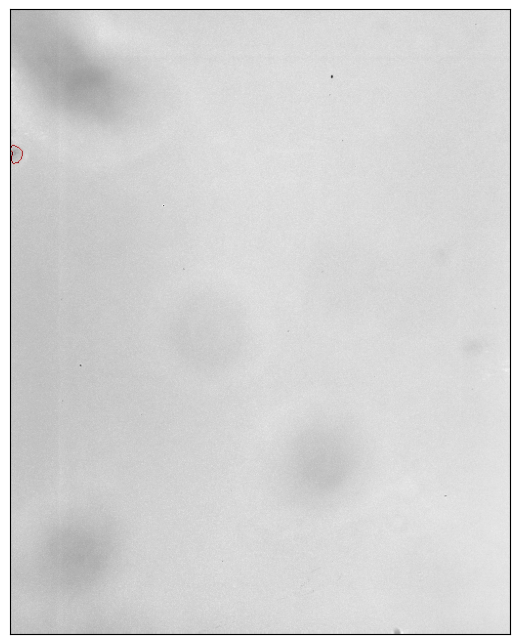

In [12]:
fig = plt.figure(figsize=(3200/640, 3200/512))
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(slope_matrix_b, cmap='gray')
ax.imshow(outlines*100, cmap='Reds', alpha=outlines, vmax=100, vmin=-100)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.savefig(r'./final_output/segb_test_{}.tiff'.format(num))

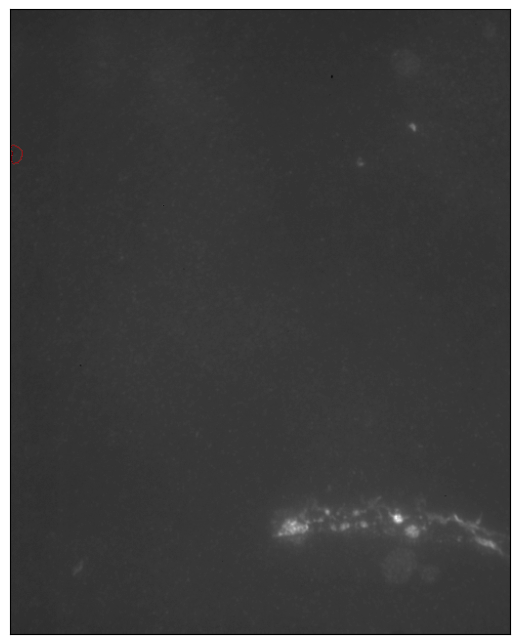

In [13]:
fig = plt.figure(figsize=(3200/640, 3200/512))
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(slope_matrix_f, cmap='gray')
ax.imshow(outlines*100, cmap='Reds', alpha=outlines, vmax=100, vmin=-100)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.savefig(r'./final_output/segf_test_{}.tiff'.format(num))

In [14]:
t_end = time.perf_counter()
print(t_end-t_start, 'seconds')

1331.1128543529994 seconds


In [15]:
mask_temp = np.zeros((640, 512,))
for index in np.argwhere(masks[0]>0):
    mask_temp[index[0]][index[1]] = 1

In [16]:
cellpose.io.save_masks([r'./save_tiff/b_test_{}.tiff'.format(num)],
                      masks=masks,
                      flows=flows,
                      file_names=[r'./output_mask/b_test_{}'.format(num)],
                      png=False,
                      tif=False,
                      save_txt=True)

In [17]:
boundaries: list = []
with open(r'./output_mask/b_test_{}_cp_outlines.txt'.format(num)) as f:
    lines = f.readlines()
    for line in lines:
        pure_line: list = line.split('\n')[0]
        pure_number: list = pure_line.split(',')
        pixel_index = [(int(pure_number[i]), int(pure_number[i+1])) for i in range(0, len(pure_number), 2)]
        boundaries.append(pixel_index)

In [20]:
cell_mask:list = []

for cell_num in range(len(boundaries)):
    h_coord = [tup[1] for tup in boundaries[cell_num]]
    w_coord = [tup[0] for tup in boundaries[cell_num]]
    h_coord = np.array(h_coord)
    w_coord = np.array(w_coord)
    if np.count_nonzero(h_coord==639) > 10 or np.count_nonzero(h_coord==1) > 10\
        or np.count_nonzero(w_coord==511) > 10 or np.count_nonzero(w_coord==1) > 10:
        print(cell_num)
        continue
    else:
        modified_boundary = [(tup[1], tup[0]) for tup in boundaries[cell_num]]
        single_mask_temp = draw.polygon2mask((640, 512), np.array(modified_boundary))
        cell_mask.append(1-single_mask_temp)

In [21]:
cell_f_sum:list = []
for single_cell_mask in cell_mask:
    cell_fluorescence = np.ma.masked_array(slope_matrix_f, single_cell_mask)
    cell_sum = np.sum(cell_fluorescence)
    cell_f_sum.append(cell_sum)

In [24]:
cell_f_sum

[255640.40659340657]

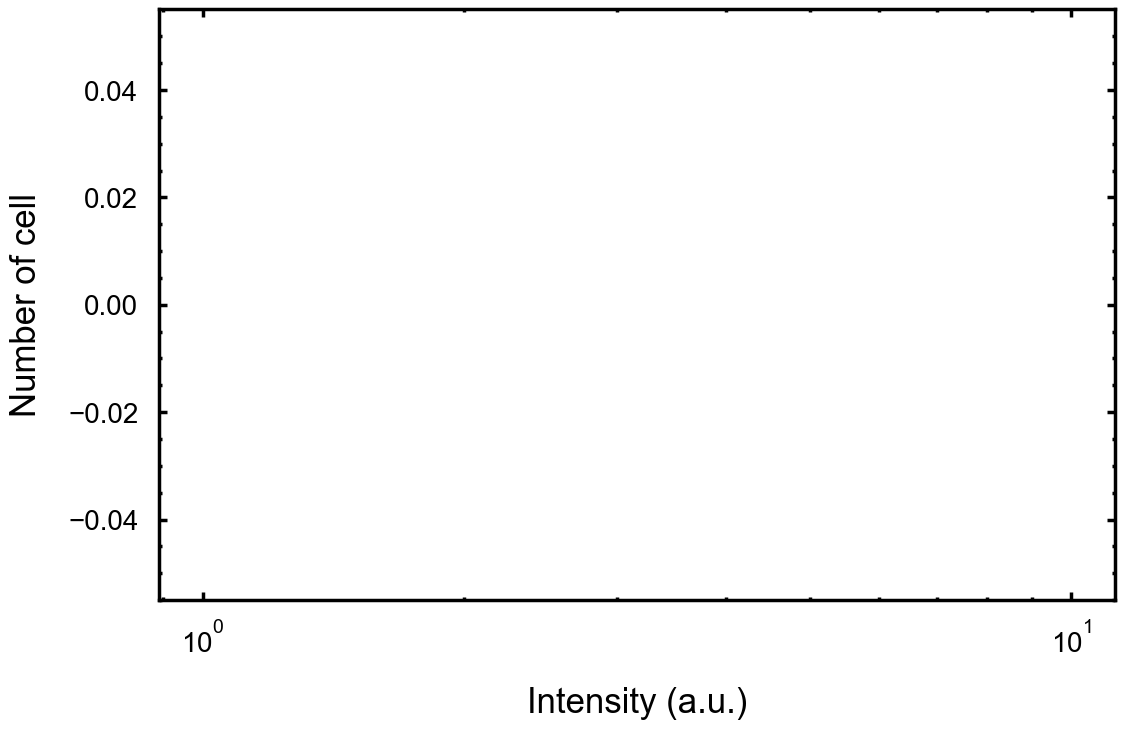

In [23]:
fig = plt.figure(figsize=(13, (13-1.5)/1.618))
ax = fig.add_axes([0.26, 0.15, 0.735, 0.735*13/(13-1.5)])

bins = np.array(sorted(cell_f_sum))
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

ax.hist(cell_f_sum, bins=logbins, color='fuchsia', edgecolor="yellow")

#ax.set_xlim(1e4, 1e7)
#ax.set_ylim(0, 25)

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xscale('log')

ax.set_xlabel('Intensity (a.u.)', fontsize=25, labelpad=20)
ax.set_ylabel('Number of cell', fontsize=25, labelpad=18)

ax.minorticks_on()
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=15/2.5, top='on', direction='in', pad=15)
ax.xaxis.set_tick_params(which='minor', labelsize=20, width=2.5, length=6/2.5, top='on', direction='in')

ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=15/2.5, right='on', direction='in', pad=15)
ax.yaxis.set_tick_params(which='minor', labelsize=20, width=2.5, length=6/2.5, right='on', direction='in')

#ax.ticklabel_format(style='plain')

for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set_linewidth(2.5)